In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

import os


%matplotlib inline
# check cuda availability
torch.cuda.is_available()
mps_device = torch.device("mps")



/var/folders/5h/xd0mtjm95gj4hw5b9__7w4g80000gn/T/ipykernel_15314/3178802222.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [9]:
IMG_DIR = '/Volumes/TaoElements/csci1470-finalproject/spectrogram_images'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 7
NUM_EPOCHS = 10
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [10]:
# Randomly select 1 spectrogram from each category for plotting
sample_files = ['136_Hip_hop_music.jpg', 
                 '6627_Pop_music.jpg',
                 '44153_Vocal.jpg',
                 '3400_Rhythm_blues.jpg',
                 '12908_Reggae.jpg',
                 '22013_Rock_music.jpg',
                 '21163_Techno.jpg']

label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }
one_hot = OneHotEncoder(categories=[range(NUM_CLASSES)])

all_files = os.listdir(IMG_DIR)

# Get class weights
label_array = []
for file_ in all_files:
    vals = file_[:-4].split('_')
    label_array.append(label_dict[vals[1]])
    
cl_weight = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(label_array), 
                                 y = label_array)

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1
                                                                     )

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/TaoElements/csci1470-finalproject/spectrogram_images136_Hip_hop_music.jpg'

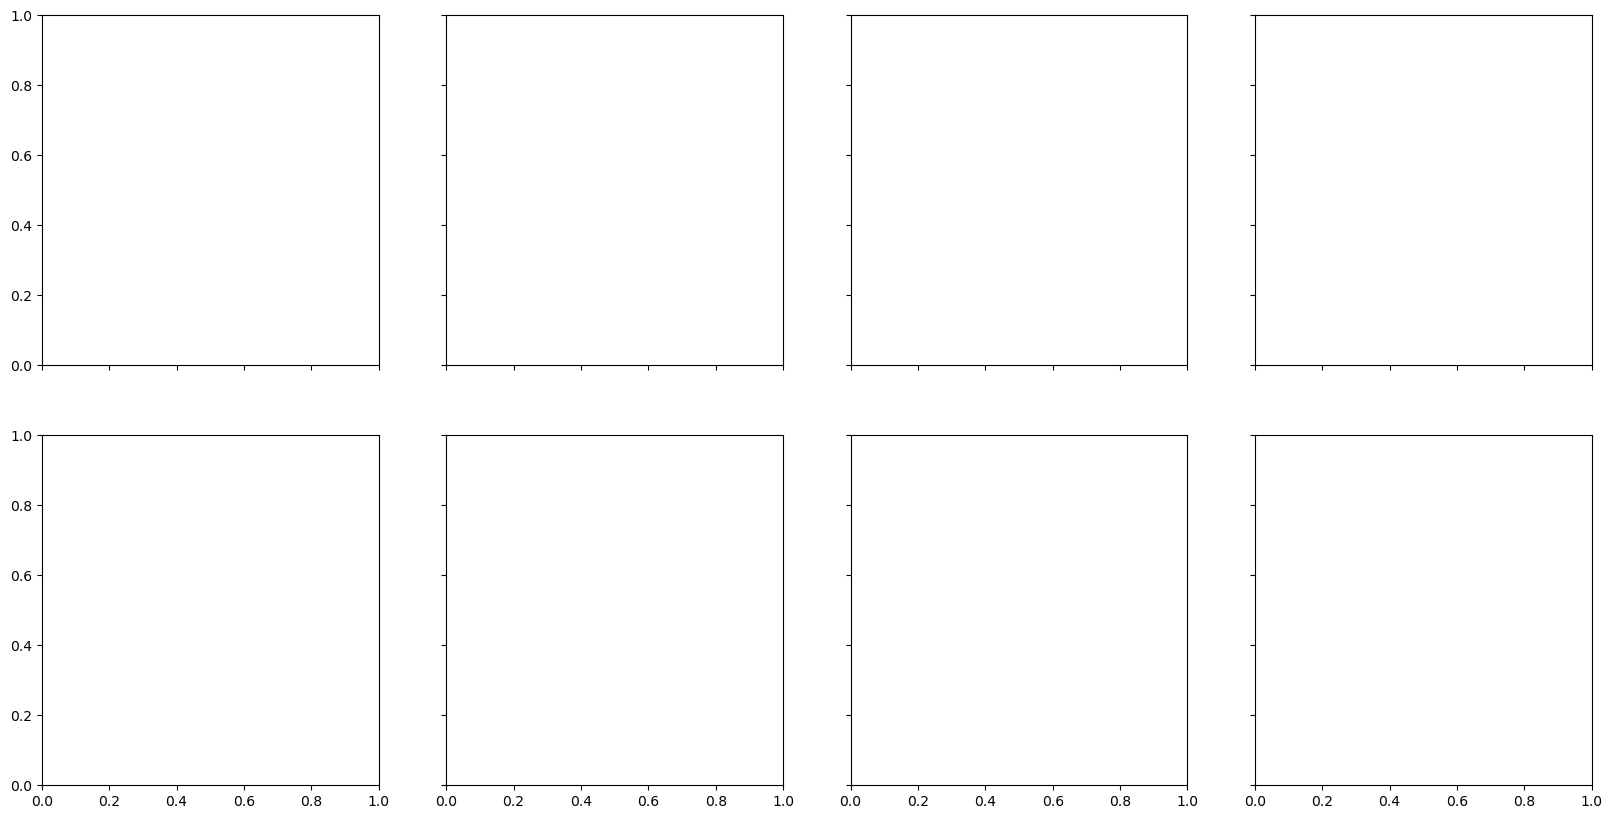

In [11]:
f, axarr = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2),(0,3), 
               (1,0),(1,1),(1,2) ]

for i, file_ in enumerate(sample_files):
    im = Image.open(IMG_DIR + file_)
    # im = im.resize((IMG_WIDTH, IMG_HEIGHT), resample = Image.ANTIALIAS)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)


In [19]:
conv_base = models.vgg16(weights = "IMAGENET1K_V1", progress=True)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
conv_base.to(mps_device)

print(mps_device)
# in_features = conv_base.Sequential.in_features
# conv_base.fc = torch.nn.Identity()

conv_base.eval()

summary(conv_base)

mps
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20          

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

In [ ]:
class L2RegularizedLinear(nn.Module):
  def __init__(self, in_features, out_features, l2_lambda):
    super(L2RegularizedLinear, self).__init__()
    self.linear = nn.Linear(in_features, out_features)
    self.l2_lambda = l2_lambda
  
  def forward(self, x):
    output = self.linear(x)
    l2_reg = torch.norm(self.linear.weight) * self.l2_lambda
    output += l2_reg
    return output


model = nn.Sequential(
  conv_base,
  nn.Flatten(),
  L2RegularizedLinear(in_features, 512, L2_LAMBDA),
  nn.Dropout(p=0.3),
  nn.ReLU(),
  nn.Linear(512, NUM_CLASSES),
  nn.Softmax()
)

In [ ]:
#Set the convolution base to not be trainable
for param in conv_base.parameters():
    param.requires_grad = False
summary(model)